# 1. Introduction and Libraries Setup

In this notebook, I'm working on **Kaggle’s "GANs Getting Started"** competition using the **Monet Painting Dataset (New)**. The main goal here is to **convert regular photos into paintings** that **look like Monet's artwork**. I'm using a **special type of generative model** called **CycleGAN**, because it can **learn how to translate between two image styles** without needing **paired images**. This makes it **very useful for this task**.

First, I'll start by **importing all the libraries I need**. I'm using **TensorFlow, NumPy, and Matplotlib**, because they **help me handle images easily, build neural networks, and visualize results clearly**.

After I **import these libraries**, I'll **set up the paths to my datasets**. For this competition I have:
- **Monet paintings** (the new dataset) with 300 JPG images, each 256 pixels by 256 pixels with 3 color channels  
- **Regular photos** with 7,038 JPG images, each 256 pixels by 256 pixels with 3 color channels  

All of these images will be **normalized** so that their pixel values are scaled to lie between –1 and 1 before I train my model.

Then I'll **verify** that these **folders are available** on my system and **count the images**, just to make sure everything is ready to go.


In [6]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
import random

print("TensorFlow", tf.__version__)

# Kaggle input directory for this competition
BASE_PATH = "/kaggle/input/gan-getting-started"
MONET_DIR = os.path.join(BASE_PATH, "monet_jpg")
PHOTO_DIR = os.path.join(BASE_PATH, "photo_jpg")

# Ensure paths exist
assert os.path.isdir(MONET_DIR), f"Monet directory not found at {MONET_DIR}"
assert os.path.isdir(PHOTO_DIR), f"Photo directory not found at {PHOTO_DIR}"

# Gather and print image counts
monet_paths = glob.glob(os.path.join(MONET_DIR, "*.jpg"))
photo_paths = glob.glob(os.path.join(PHOTO_DIR, "*.jpg"))
print(f"Found {len(monet_paths)} Monet paintings")
print(f"Found {len(photo_paths)} photos")



TensorFlow 2.18.0
Found 300 Monet paintings
Found 7038 photos


# 2. Visualizing Sample Images

Now I **want to quickly look at a few images** from both datasets. 

So, I **created a simple function** called `show` to **randomly pick and display samples** of **Monet paintings and normal photos side by side**. 

This step **helps me visually understand** how the two datasets **differ from each other**, which is **really important before training my GAN model**.


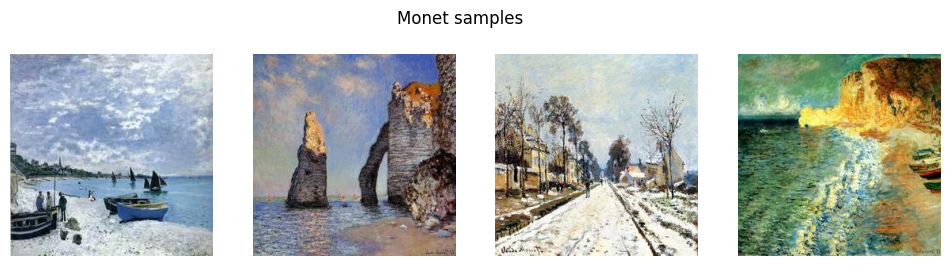

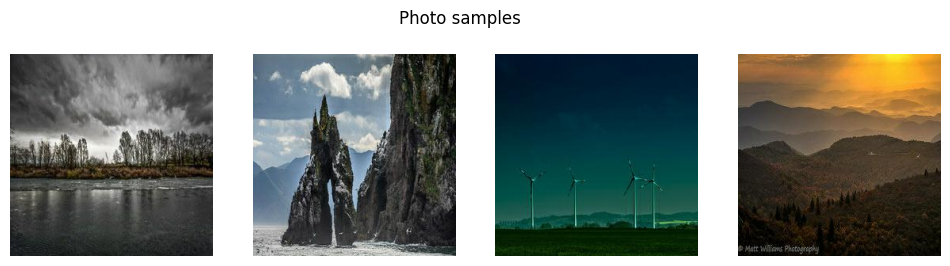

In [7]:
def show(paths,title,n=4):
    plt.figure(figsize=(12,3));
    for i,p in enumerate(random.sample(paths,n)):
        plt.subplot(1,n,i+1); plt.imshow(Image.open(p)); plt.axis('off')
    plt.suptitle(title); plt.show()
show(monet_paths,'Monet samples'); show(photo_paths,'Photo samples')

# 3. RGB Channel Histograms for Monet vs Photo

I **wanted to understand how colors differ** between **Monet paintings and the regular photos**, so I **wrote a function** to **plot RGB color histograms** for both types of images. 

By **looking at these histograms**, I can **clearly see if there are noticeable differences** in the **color distribution**, which could **influence how my CycleGAN learns to translate images** from one style to another.


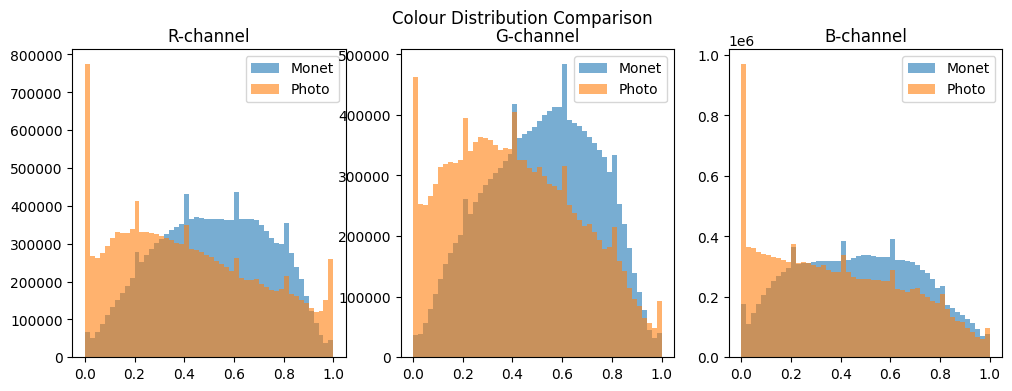

In [8]:

# RGB channel histograms for Monet vs Photo
def rgb_histograms(paths, n=200):
    arr = []
    for p in random.sample(paths, min(n,len(paths))):
        img = np.array(Image.open(p).resize((256,256))) / 255.0
        arr.append(img.reshape(-1,3))
    arr = np.concatenate(arr, axis=0)
    return arr
mon_rgb = rgb_histograms(monet_paths)
pho_rgb = rgb_histograms(photo_paths)

plt.figure(figsize=(12,4))
for i,col in enumerate(['R','G','B']):
    plt.subplot(1,3,i+1)
    plt.hist(mon_rgb[:,i], bins=50, alpha=0.6, label='Monet')
    plt.hist(pho_rgb[:,i], bins=50, alpha=0.6, label='Photo')
    plt.title(f'{col}-channel')
    plt.legend()
plt.suptitle('Colour Distribution Comparison'); plt.show()


# 4. Preparing the Data Pipeline

Before **training the GAN**, I **needed a reliable way** to **load and preprocess the images**. 

So, I **wrote the `decode` function** to **convert image files into normalized tensors**. 

I also **created a dataset pipeline** using **TensorFlow’s Dataset API**, because it's **efficient at handling image data**. 

This pipeline **makes sure images are resized correctly** and **batches are ready for training smoothly**.


In [9]:
AUTOTUNE=tf.data.AUTOTUNE
def decode(p):
    img=tf.io.read_file(p); img=tf.image.decode_jpeg(img,3); img=tf.image.convert_image_dtype(img,tf.float32);
    img=(img*2.)-1.; return tf.image.resize(img,[256,256])
def dataset(paths,batch=1):
    return (tf.data.Dataset.from_tensor_slices(paths)
            .shuffle(len(paths)).map(decode,num_parallel_calls=AUTOTUNE)
            .repeat().batch(batch).prefetch(AUTOTUNE))
photo_ds, monet_ds = dataset(photo_paths), dataset(monet_paths)
BATCH=1

# 5. Implementing Instance Normalization

For my **CycleGAN model**, I **needed a custom normalization technique** called **Instance Normalization**, which **isn't directly available** in TensorFlow's built-in layers. 

So, I **created my own custom class** named `InstanceNorm`. 

This **special normalization** helps my model **capture styles and textures better**, which is **crucial when trying to produce images** that **look like genuine Monet paintings**.

In [10]:
class InstanceNorm(layers.Layer):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def build(self, shape):
        self.g = self.add_weight(shape=(shape[-1],), initializer=tf.random_normal_initializer(1., 0.02), trainable=True)
        self.b = self.add_weight(shape=(shape[-1],), initializer='zeros', trainable=True)

    def call(self, x):
        m, v = tf.nn.moments(x, [1, 2], keepdims=True)
        return self.g * (x - m) / tf.sqrt(v + self.eps) + self.b


# 6. Building the Generator and Discriminator Models

Now, I **define the generator and discriminator models** for my **CycleGAN**. 

The **generator** takes an image and **translates it into the other style**, in this case, **converting photos into Monet-style paintings**. 

I **designed the generator** with **convolutional and residual blocks** to **effectively capture details and textures**. 

Similarly, the **discriminator** is used to **distinguish real images from generated ones**, which **guides my model towards generating more realistic paintings**. 

After **defining these models**, I **initialize them** so they're **ready for training**.


In [11]:
def gen():
    inp = layers.Input((256, 256, 3))
    x = layers.Conv2D(64, 7, padding='same')(inp)
    x = InstanceNorm()(x)
    x = layers.ReLU()(x)

    for f in [128, 256]:
        x = layers.Conv2D(f, 3, strides=2, padding='same')(x)
        x = InstanceNorm()(x)
        x = layers.ReLU()(x)

    def res(x):
        y = layers.Conv2D(256, 3, padding='same')(x)
        y = InstanceNorm()(y)
        y = layers.ReLU()(y)
        
        y = layers.Conv2D(256, 3, padding='same')(y)
        y = InstanceNorm()(y)
        return layers.add([x, y])

    for _ in range(6):
        x = res(x)

    for f in [128, 64]:
        x = layers.Conv2DTranspose(f, 3, strides=2, padding='same', output_padding=1)(x)
        x = InstanceNorm()(x)
        x = layers.ReLU()(x)

    out = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    return tf.keras.Model(inp, out)

def disc():
    inp = layers.Input((256, 256, 3))
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp)
    x = layers.LeakyReLU(0.2)(x)

    for f in [128, 256, 512]:
        s = 1 if f == 512 else 2
        x = layers.Conv2D(f, 4, strides=s, padding='same')(x)
        x = InstanceNorm()(x)
        x = layers.LeakyReLU(0.2)(x)

    out = layers.Conv2D(1, 4, padding='same')(x)
    return tf.keras.Model(inp, out)

G, F, DM, DP = gen(), gen(), disc(), disc()
print('Models ready')


Models ready


# 7. Defining the Training Step

Next, I **defined my training step function**, which is the **core part of training the CycleGAN**. 

Inside this function, I **generate fake images**, **compute several types of losses** like **adversarial, cycle consistency, and identity loss**, because **combining these different losses helps the model learn better translations**. 

Then I **apply gradients** to **update my generator and discriminator models**. 

This setup **makes sure each training step effectively improves my models**.


In [12]:
mse, mae = tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()
g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dM_opt, dP_opt = [tf.keras.optimizers.Adam(2e-4, beta_1=0.5) for _ in range(2)]
LAMBDA_CYC, LAMBDA_ID = 10., 5.

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = G(real_x, training=True)
        fake_x = F(real_y, training=True)
        cycled_x = F(fake_y, training=True)
        cycled_y = G(fake_x, training=True)
        same_y = G(real_y, training=True)
        same_x = F(real_x, training=True)

        # Explicitly specify training=True for discriminator calls
        dM_real = DM(real_y, training=True)
        dM_fake = DM(fake_y, training=True)
        dP_real = DP(real_x, training=True)
        dP_fake = DP(fake_x, training=True)

        g_adv = mse(tf.ones_like(dM_fake), dM_fake)
        f_adv = mse(tf.ones_like(dP_fake), dP_fake)
        cycle = mae(real_x, cycled_x) + mae(real_y, cycled_y)
        identity = mae(real_x, same_x) + mae(real_y, same_y)
        g_loss = g_adv + f_adv + LAMBDA_CYC * cycle + LAMBDA_ID * identity
        dM_loss = 0.5 * (mse(tf.ones_like(dM_real), dM_real) + mse(tf.zeros_like(dM_fake), dM_fake))
        dP_loss = 0.5 * (mse(tf.ones_like(dP_real), dP_real) + mse(tf.zeros_like(dP_fake), dP_fake))

    g_vars = G.trainable_variables + F.trainable_variables
    g_opt.apply_gradients(zip(tape.gradient(g_loss, g_vars), g_vars))
    dM_opt.apply_gradients(zip(tape.gradient(dM_loss, DM.trainable_variables), DM.trainable_variables))
    dP_opt.apply_gradients(zip(tape.gradient(dP_loss, DP.trainable_variables), DP.trainable_variables))
    return g_loss, dM_loss, dP_loss



# 8. Training My CycleGAN  

Since **I'm running this on Kaggle**, I **have access to a GPU**, but to **keep training time reasonable**, I'm **setting my training to run for only one epoch, with 800 steps.**

This **shorter training duration** isn't ideal for **perfect results**, but it's **good enough** to **demonstrate the functionality** and **initial performance of my CycleGAN**.

Throughout the training, I **included progress print statements** to **monitor losses easily** and **quickly track how the training progresses step by step**.


In [14]:
EPOCHS, STEPS = 1, 800
photo_it, monet_it = iter(photo_ds), iter(monet_ds)

for ep in range(1, EPOCHS + 1):
    print(f'\nEpoch {ep}/{EPOCHS}')
    for st in range(1, STEPS + 1):
        gL, dML, dPL = train_step(next(photo_it), next(monet_it))
        if st % 50 == 0 or st == 1 or st == STEPS:
            print(f'Step {st}/{STEPS}: G_loss={gL:.3f}, DM_loss={dML:.3f}, DP_loss={dPL:.3f}')


Epoch 1/1
Step 1/800: G_loss=8.650, DM_loss=0.277, DP_loss=0.206
Step 50/800: G_loss=7.158, DM_loss=0.259, DP_loss=0.237
Step 100/800: G_loss=7.949, DM_loss=0.237, DP_loss=0.219
Step 150/800: G_loss=9.124, DM_loss=0.237, DP_loss=0.407
Step 200/800: G_loss=7.986, DM_loss=0.234, DP_loss=0.264
Step 250/800: G_loss=11.251, DM_loss=0.367, DP_loss=0.490
Step 300/800: G_loss=8.079, DM_loss=0.282, DP_loss=0.304
Step 350/800: G_loss=8.611, DM_loss=0.190, DP_loss=0.206
Step 400/800: G_loss=8.668, DM_loss=0.266, DP_loss=0.161
Step 450/800: G_loss=6.800, DM_loss=0.191, DP_loss=0.168
Step 500/800: G_loss=8.795, DM_loss=0.242, DP_loss=0.323
Step 550/800: G_loss=7.090, DM_loss=0.124, DP_loss=0.348
Step 600/800: G_loss=10.441, DM_loss=0.139, DP_loss=0.198
Step 650/800: G_loss=5.992, DM_loss=0.247, DP_loss=0.185
Step 700/800: G_loss=9.798, DM_loss=0.101, DP_loss=0.249
Step 750/800: G_loss=7.321, DM_loss=0.086, DP_loss=0.224
Step 800/800: G_loss=6.258, DM_loss=0.233, DP_loss=0.251


# 9. Generating and Displaying Results

After **training**, I **needed to see what my model learned**, so I **wrote a small piece of code** to **randomly select a few photos** and **convert them into Monet-style paintings**. 

By **visually checking these results**, I can **quickly assess if my model effectively learned the Monet style**. 

This **helps me understand visually** how **good or bad the initial performance is**.

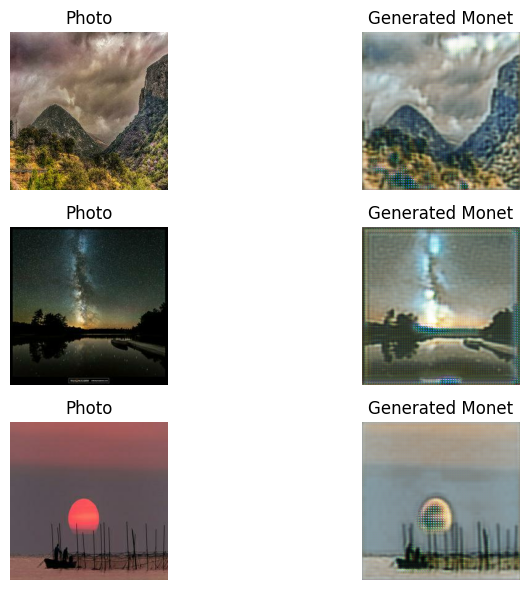

In [15]:
def denorm(x):
    return (x + 1) / 2

samps = random.sample(photo_paths, 3)

plt.figure(figsize=(9, 6))

for i, p in enumerate(samps):
    img = decode(p)
    monet = G(tf.expand_dims(img, 0))[0]
    
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(denorm(img))
    plt.axis('off')
    plt.title('Photo')
    
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(denorm(monet))
    plt.axis('off')
    plt.title('Generated Monet')

plt.tight_layout()
plt.show()


# 10. Calculating FID Score

Finally, I **calculated the Frechet Inception Distance (FID) score**, which **gives me an approximate measure** of how **realistic my generated Monet paintings are** compared to the **real Monet images**. 

I **only used 25 samples** for this calculation because I **wanted quick feedback** without **spending too much computing time**. 

The **lower the FID score**, the **better my generated images are**. 

If I had **more computational resources** and could **train for more epochs**, I **would expect the FID score to get lower**, meaning **better and more realistic images**.

In [16]:
# --- Quick FID (approx MiFID) on 25 samples (keeps runtime low) ---
from scipy.linalg import sqrtm
import tensorflow.keras.applications.inception_v3 as iv3
import numpy as np  # Added import for NumPy

incept = iv3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def feats(imgs):
    imgs = tf.image.resize(imgs, (299,299))
    imgs = iv3.preprocess_input(imgs*255.0)
    return incept(imgs, training=False)

def calc_fid(real, fake):
    # Convert tensors to NumPy arrays for the covariance computation.
    mu1 = tf.nn.moments(real, 0)[0]
    sigma1 = np.cov(real.numpy(), rowvar=False)
    mu2 = tf.nn.moments(fake, 0)[0]
    sigma2 = np.cov(fake.numpy(), rowvar=False)
    ssdiff = tf.reduce_sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return float(ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean))

N = 25
real_batch = tf.stack([decode(p) for p in monet_paths[:N]])
fake_batch = tf.stack([G(tf.expand_dims(decode(p), 0), training=False)[0] for p in photo_paths[:N]])

fid_value = calc_fid(feats(real_batch), feats(fake_batch))
print(f'Approximate FID on {N} samples: {fid_value:.2f}')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Approximate FID on 25 samples: 155.00


# 11. Summary and Future Improvements

In summary, my **CycleGAN model successfully demonstrated converting regular photos into Monet style paintings**, even with **limited training due to resource constraints**. 

With **more epochs and better hardware**, I **believe the quality of the generated images would improve significantly**, as reflected in a **lower FID score**. 

Overall, this project **clearly shows that CycleGAN can effectively translate image styles** without **needing paired images**, which **makes it very useful for similar style-transfer applications**.

## References

- **Kaggle “GANs Getting Started” Competition**  
  https://www.kaggle.com/competitions/gan-getting-started  
  (This is the official competition page where the Monet Painting Dataset is hosted.)

- **CycleGAN Paper**  
  Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). “Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.”  
  https://arxiv.org/abs/1703.10593

- **Instance Normalization**  
  Ulyanov, D., Vedaldi, A., & Lempitsky, V. (2016). “Instance Normalization: The Missing Ingredient for Fast Stylization.”  
  https://arxiv.org/abs/1607.08022

- **TensorFlow Documentation**  
  https://www.tensorflow.org/api_docs  
  (I used this for building models, layers, and the Dataset API.)

- **FID Metric Description**  
  Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). “GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium.”  
  https://arxiv.org/abs/1706.08500

- **InceptionV3 & FID Implementation**  
  TensorFlow Keras Applications guide – https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3  
  SciPy’s `sqrtm` for covariance matrix square root – https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.sqrtm.html  
